In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [2]:
DATABASE = "../database.db"

In [3]:
EIGHT_HOURS_MS = 1000 * 60 * 60 * 8
EIGHT_HOURS_MS

28800000

In [4]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    CREATE OR REPLACE TABLE prediction_comparison AS
    SELECT
        r.report_id,
        p.player_id,
        p.name,
        uga.week,
        uga.team,
        uga.opponent AS opp,
        strftime(to_timestamp(r.published_at / 1000), '%m/%d %I:%M %p') AS published_at,
        strftime(to_timestamp(ug.started_at / 1000), '%m/%d %I:%M %p') AS started_at,
        to_timestamp(ug.started_at / 1000)::date = to_timestamp(r.published_at / 1000)::date AS published_same_day,
        (ug.started_at - r.published_at) <= 28800000 AS published_within_eight_hours,
        ugo.was_played,
        ugo.ppr_scoring_fantasy_points,
        ugo.ppr_scoring_position_rank,
        ugo.rushing_attempts AS att,
        ugo.receiving_targets AS tgt,
        att + tgt AS touches,
        CASE
            WHEN touches >= 20 THEN 'high'
            WHEN touches >= 10 THEN 'medium'
            WHEN touches < 10 THEN 'low'
            ELSE 'unknown'
        END AS actual,
        rp.expected_workload AS expect,
        rp.reason_category AS reason,
        if(actual = 'low', 1, 0) AS is_lo,
        if(expect = 'low' AND actual = 'low', 1, 0) AS tp_lo,
        if(expect = 'low' AND actual != 'low', 1, 0) AS fp_lo,
        if(expect != 'low' AND actual = 'low', 1, 0) AS fn_lo,
        if(actual = 'medium', 1, 0) AS is_md,
        if(expect = 'medium' AND actual = 'medium', 1, 0) AS tp_md,
        if(expect = 'medium' AND actual != 'medium', 1, 0) AS fp_md,
        if(expect != 'medium' AND actual = 'medium', 1, 0) AS fn_md,
        if(actual = 'high', 1, 0) AS is_hi,
        if(expect = 'high' AND actual = 'high', 1, 0) AS tp_hi,
        if(expect = 'high' AND actual != 'high', 1, 0) AS fp_hi,
        if(expect != 'high' AND actual = 'high', 1, 0) AS fn_hi,
    FROM comparable_report c
    LEFT JOIN report r
        ON c.report_id = r.report_id
    LEFT JOIN report_game_assignment a
        ON r.report_id = a.report_id
    LEFT JOIN game ug
        ON a.upcoming_game_id = ug.game_id
    LEFT JOIN player_game_assignment uga
        ON a.upcoming_game_id = uga.game_id
        AND r.player_id = uga.player_id
    LEFT JOIN player_game_outcome ugo
        ON uga.game_id = ugo.game_id
        AND uga.player_id = ugo.player_id
    LEFT JOIN report_prediction rp
        ON r.report_id = rp.report_id
    LEFT JOIN player p
        ON r.player_id = p.player_id
    ORDER BY
        ugo.season ASC,
        r.player_id ASC,
        ugo.week ASC
    ;
    """)

    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    LIMIT 20
    ;
    """).show()

┌───────────────────┬────────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────────┐
│     report_id     │      name      │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │   reason    │
│      varchar      │    varchar     │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │   varchar   │
├───────────────────┼────────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────────┤
│ rotoballer_201624 │ Kyle Juszczyk  │     3 │ SF      │ ARI     │     0 │     1 │       1 │ low     │ low     │ injury      │
│ rotoballer_202429 │ Kyle Juszczyk  │     4 │ SF      │ JAX     │     0 │     3 │       3 │ low     │ unknown │ unknown     │
│ rotoballer_209624 │ Kyle Juszczyk  │    15 │ SF      │ TEN     │     0 │     1 │       1 │ low     │ low     │ injury      │
│ rotoballer_211587 │ Ameer Abdullah │    16 │ IND     │ SF      │     0 │     1 │       1 │ low     │ low     

In [5]:
def show_report_detail(report_id: str):
    value = {}
    with duckdb.connect(DATABASE) as con:
        cur = con.sql("""
        SELECT
            r.title,
            r.description,
            pc.name AS player_name,
            pc.week,
            pc.team,
            pc.opp,
            pc.att,
            pc.tgt,
            pc.touches,
            pc.actual,
            pc.expect,
            pc.reason,
            pc.ppr_scoring_fantasy_points,
            pc.ppr_scoring_position_rank,
        FROM report r
        LEFT JOIN prediction_comparison pc
            ON r.report_id = pc.report_id
        WHERE r.report_id = '{report_id}'
        ;
        """.format(report_id=report_id))
        value = cur.df().to_dict(orient="records")[0]
    
    print(f"""
Matchup:
Week {value.get("week")}: {value.get("team")} against {value.get("opp")}

Player:
{value.get("player_name")}

Report:
{value.get("title")}
---
{value.get("description")}

Expected Workload:
{value.get("expect")} (due to {value.get("reason")})

Actual Workload:
{value.get("actual")} ({value.get("touches")} touches)
  {value.get("att")} carries
  {value.get("tgt")} targets

Fantasy Value:
  PPR Points: {value.get("ppr_scoring_fantasy_points")}
  Position Rank: #{value.get("ppr_scoring_position_rank")}
    """.strip())

In [6]:
LABELS_WORKLOAD_WITH_UNKNOWN = ["low", "medium", "high", "unknown"]
LABELS_WORKLOAD_WITHOUT_UNKNOWN = ["low", "medium", "high"]
LABELS_REASON = ["performance", "injury", "opponent", "unknown"]

classification_cmap = sns.color_palette("viridis", as_cmap=True)

def plot_confusion_matrix(ys, title, cmap):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    fig.suptitle(title)
    
    y_real = [y.get("actual") for y in ys]
    y_pred = [y.get("expect") for y in ys]
    cm = confusion_matrix(y_real, y_pred, labels=LABELS_WORKLOAD_WITH_UNKNOWN)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_WORKLOAD_WITH_UNKNOWN)
    disp.plot(ax=ax, cmap=cmap)
    ax.set_title("Workload")
    
    return fig

In [7]:
predictions = []
with duckdb.connect(DATABASE) as con:
    cur = con.sql("""
    SELECT
        actual,
        expect,
    FROM prediction_comparison
    """)
    df_rows = cur.df()
    records = df_rows.to_dict(orient="records")
    predictions.extend(records)

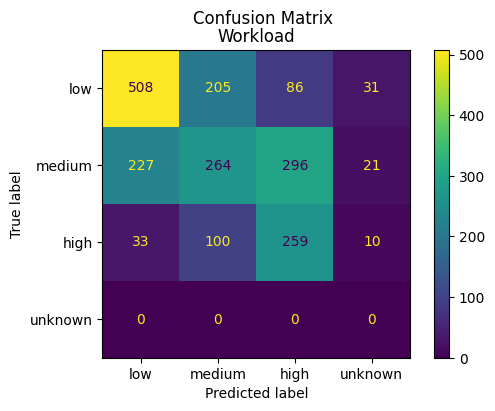

In [8]:
plot_confusion_matrix(predictions, title="Confusion Matrix", cmap=classification_cmap)
plt.show()

In [9]:
y_real = [y.get("actual") for y in predictions]
y_pred = [y.get("expect") for y in predictions]

prc_micro = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="micro")
prc_macro = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="macro")
prc_weighted = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="weighted")

rec_micro = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="micro")
rec_macro = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="macro", zero_division=np.nan)
rec_weighted = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="weighted", zero_division=np.nan)

print(f"""
Precision
  Micro:    {(prc_micro * 100):.3f}%
  Macro:    {(prc_macro * 100):.3f}%
  Weighted: {(prc_weighted * 100):.3f}%

Recall
  Micro:    {(rec_micro * 100):.3f}%
  Macro:    {(rec_macro * 100):.3f}%
  Weighted: {(rec_weighted * 100):.3f}%
""".strip())

cls_scores = zip(
    LABELS_WORKLOAD_WITHOUT_UNKNOWN,
    precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average=None),
    recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average=None, zero_division=np.nan),
)
print("\nClass\t\tPrecision\tRecall")
for cls, prc, rc in cls_scores:
    print(f"{cls}\t\t{(prc * 100):.3f}%\t\t{(rc * 100):.3f}%")

Precision
  Micro:    52.123%
  Macro:    50.983%
  Weighted: 53.251%

Recall
  Micro:    50.539%
  Macro:    52.769%
  Weighted: 50.539%

Class		Precision	Recall
low		66.146%		61.205%
medium		46.397%		32.673%
high		40.406%		64.428%


In [10]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
        FROM prediction_comparison
    )
    SELECT
        format('{:.3f}%', micro_prc * 100) AS micro_precision,
        format('{:.3f}%', macro_prc * 100) AS macro_precision,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
    FROM metrics
    ;
    """).show()

┌─────────────────┬─────────────────┬────────────────────┐
│ micro_precision │ macro_precision │ weighted_precision │
│     varchar     │     varchar     │      varchar       │
├─────────────────┼─────────────────┼────────────────────┤
│ 52.123%         │ 50.983%         │ 53.251%            │
└─────────────────┴─────────────────┴────────────────────┘



In [11]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            reason,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
        FROM prediction_comparison
        GROUP BY reason
        ORDER BY wgt_prc DESC
    )
    SELECT
        reason,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
        format('{:.3f}%', prc_lo * 100) AS precision_lo,
        format('{:.3f}%', prc_md * 100) AS precision_md,
        format('{:.3f}%', prc_hi * 100) AS precision_hi,
    FROM metrics
    ;
    """).show()

┌─────────────┬────────────────────┬─────────────────┬──────────────┬──────────────┬──────────────┐
│   reason    │ weighted_precision │ weighted_recall │ precision_lo │ precision_md │ precision_hi │
│   varchar   │      varchar       │     varchar     │   varchar    │   varchar    │   varchar    │
├─────────────┼────────────────────┼─────────────────┼──────────────┼──────────────┼──────────────┤
│ performance │ 55.011%            │ 54.115%         │ 67.917%      │ 49.130%      │ 47.734%      │
│ injury      │ 54.026%            │ 50.000%         │ 70.171%      │ 38.813%      │ 29.577%      │
│ opponent    │ 50.707%            │ 47.987%         │ 46.000%      │ 57.692%      │ 39.362%      │
│ unknown     │ 48.882%            │ 27.143%         │ 63.158%      │ 37.500%      │ 33.333%      │
└─────────────┴────────────────────┴─────────────────┴──────────────┴──────────────┴──────────────┘



In [12]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            week,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
        FROM prediction_comparison
        GROUP BY week
        ORDER BY week ASC
    )
    SELECT
        week,
        reports,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
    FROM metrics
    ;
    """).show()

┌───────┬─────────┬────────────────────┬─────────────────┐
│ week  │ reports │ weighted_precision │ weighted_recall │
│ int64 │  int64  │      varchar       │     varchar     │
├───────┼─────────┼────────────────────┼─────────────────┤
│     2 │      38 │ 53.935%            │ 55.263%         │
│     3 │      46 │ 73.278%            │ 71.739%         │
│     4 │      49 │ 52.521%            │ 48.980%         │
│     5 │      87 │ 74.513%            │ 65.517%         │
│     6 │     148 │ 56.219%            │ 54.730%         │
│     7 │     125 │ 52.933%            │ 48.000%         │
│     8 │     124 │ 44.805%            │ 37.097%         │
│     9 │     146 │ 59.316%            │ 56.849%         │
│    10 │     177 │ 44.769%            │ 43.503%         │
│    11 │     168 │ 52.744%            │ 50.000%         │
│    12 │     147 │ 54.982%            │ 47.619%         │
│    13 │     166 │ 51.086%            │ 50.602%         │
│    14 │     151 │ 57.560%            │ 52.318%        

In [13]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            player_id,
            max(name) AS player_name,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
            sum(was_played) AS games,
        FROM prediction_comparison
        GROUP BY player_id
    )
    SELECT
        player_id,
        player_name,
        reports,
        games,
        format('{:.1f}%', micro_prc * 100) AS micro_precision,
        format('{:.1f}%', micro_rec * 100) AS micro_recall,
    FROM metrics
    WHERE NOT isnan(micro_prc)
    ORDER BY
        micro_prc DESC,
        games DESC
    LIMIT 10
    ;
    """).show()

┌───────────┬────────────────┬─────────┬────────┬─────────────────┬──────────────┐
│ player_id │  player_name   │ reports │ games  │ micro_precision │ micro_recall │
│   int64   │    varchar     │  int64  │ int128 │     varchar     │   varchar    │
├───────────┼────────────────┼─────────┼────────┼─────────────────┼──────────────┤
│      2749 │ Raheem Mostert │       6 │      6 │ 100.0%          │ 83.3%        │
│      6012 │ Travis Homer   │       4 │      4 │ 100.0%          │ 100.0%       │
│      1379 │ Kyle Juszczyk  │       3 │      3 │ 100.0%          │ 66.7%        │
│      6828 │ A.J. Dillon    │       3 │      3 │ 100.0%          │ 100.0%       │
│      4137 │ James Conner   │       7 │      3 │ 100.0%          │ 100.0%       │
│     11299 │ Zavier Scott   │       3 │      3 │ 100.0%          │ 100.0%       │
│     11577 │ Will Shipley   │       3 │      3 │ 100.0%          │ 100.0%       │
│     12504 │ Kaleb Johnson  │       4 │      3 │ 100.0%          │ 100.0%       │
│   

In [14]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE player_id = 4137
    LIMIT 20
    ;
    """).show()

┌───────────────────┬──────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────────┐
│     report_id     │     name     │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │   reason    │
│      varchar      │   varchar    │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │   varchar   │
├───────────────────┼──────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────────┤
│ rotoballer_201502 │ James Conner │     2 │ ARI     │ CAR     │    11 │     1 │      12 │ medium  │ medium  │ opponent    │
│ rotoballer_201082 │ James Conner │     2 │ ARI     │ CAR     │    11 │     1 │      12 │ medium  │ medium  │ performance │
│ rotoballer_202091 │ James Conner │     3 │ ARI     │ SF      │     9 │     4 │      13 │ medium  │ medium  │ opponent    │
│ rotoballer_202321 │ James Conner │     4 │ ARI     │ SEA     │     0 │     0 │       0 │ low     │ low     │ injury      │


In [15]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            published_same_day,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
        FROM prediction_comparison
        GROUP BY published_same_day
        ORDER BY published_same_day DESC
    )
    SELECT
        published_same_day,
        reports,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
        format('{:.3f}%', prc_lo * 100) AS precision_lo,
        format('{:.3f}%', prc_md * 100) AS precision_md,
        format('{:.3f}%', prc_hi * 100) AS precision_hi,
    FROM metrics
    ;
    """).show()

┌────────────────────┬─────────┬────────────────────┬─────────────────┬──────────────┬──────────────┬──────────────┐
│ published_same_day │ reports │ weighted_precision │ weighted_recall │ precision_lo │ precision_md │ precision_hi │
│      boolean       │  int64  │      varchar       │     varchar     │   varchar    │   varchar    │   varchar    │
├────────────────────┼─────────┼────────────────────┼─────────────────┼──────────────┼──────────────┼──────────────┤
│ true               │     111 │ 49.394%            │ 47.748%         │ 62.222%      │ 41.667%      │ 38.462%      │
│ false              │    1929 │ 53.457%            │ 50.700%         │ 66.390%      │ 46.606%      │ 40.532%      │
└────────────────────┴─────────┴────────────────────┴─────────────────┴──────────────┴──────────────┴──────────────┘



In [16]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE
        reason = 'opponent'
        AND expect = 'high'
        AND actual = 'high'
    ORDER BY touches DESC
    LIMIT 10
    ;
    """).show()

┌───────────────────┬─────────────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬──────────┐
│     report_id     │        name         │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │  reason  │
│      varchar      │       varchar       │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │ varchar  │
├───────────────────┼─────────────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼──────────┤
│ rotoballer_207062 │ Jonathan Taylor     │    10 │ IND     │ ATL     │    32 │     3 │      35 │ high    │ high    │ opponent │
│ rotoballer_206697 │ Jonathan Taylor     │    10 │ IND     │ ATL     │    32 │     3 │      35 │ high    │ high    │ opponent │
│ rotoballer_209391 │ James Cook          │    13 │ BUF     │ PIT     │    32 │     3 │      35 │ high    │ high    │ opponent │
│ rotoballer_208575 │ Christian McCaffrey │    12 │ SF      │ CAR     │    24 │     7 │      31 │

In [17]:
show_report_detail("rotoballer_210400")

Matchup:
Week 15: ATL against TB

Player:
Bijan Robinson

Report:
Bijan Robinson a Top Option at Running Back for Week 15 on TNF
---
Atlanta Falcons running back Bijan Robinson put up solid numbers on the ground in Week 14, rushing 20 times for 86 yards, however, he caught just two passes for eight yards and did not score. Despite getting down big in the second half, Kirk Cousins targeted the 2024 Pro Bowler just two times, which was as many targets as Tyler Allgeier received, while Dylan Drummond and David Sills V combined for nine targets. Robinson was averaging over six targets per game with Michael Penix Jr. (knee) under center, but has seen that total drop to just over three targets per contest with Cousins, which has lowered his fantasy floor at the worst possible time for fantasy managers. Even so, on Thursday night, the 23-year-old faces a Buccaneers defense that has been easier to run on than they have been in recent years despite the presence of run-stuffing Vita Vea, yieldin

In [18]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE
        player_id = 7021
        AND week = 5
    ORDER BY week ASC
    LIMIT 10
    ;
    """).show()

┌───────────────────┬─────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────┐
│     report_id     │    name     │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │ reason  │
│      varchar      │   varchar   │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │ varchar │
├───────────────────┼─────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────┤
│ rotoballer_203375 │ Rico Dowdle │     5 │ CAR     │ MIA     │    23 │     4 │      27 │ high    │ high    │ injury  │
│ rotoballer_203659 │ Rico Dowdle │     5 │ CAR     │ MIA     │    23 │     4 │      27 │ high    │ high    │ injury  │
└───────────────────┴─────────────┴───────┴─────────┴─────────┴───────┴───────┴─────────┴─────────┴─────────┴─────────┘



In [19]:
show_report_detail("rotoballer_203375")

Matchup:
Week 5: CAR against MIA

Player:
Rico Dowdle

Report:
Rico Dowdle in Line For an Increased Workload in Week 5
---
Carolina Panthers running back and former Dallas Cowboy, Rico Dowdle, is set to be the lead back in the Panthers' backfield in Week 5 against the Miami Dolphins, with Chuba Hubbard (calf) ruled out for Week 5. Hubbard is considered week-to-week, so Dowdle isn't expected to be a hot commodity for a season-long play, but he immediately rises in the Week 5 ranks and becomes a top-25 running back against the Dolphins defense, which allows the seventh most fantasy points to the running back position. Dowdle is no slouch either; last year with the Cowboys, he accumulated 1,328 all-purpose yards and five touchdowns. Rookie running back Trevor Etienne becomes the team's RB2 and should also be in line for additional carries.

Expected Workload:
high (due to injury)

Actual Workload:
high (27 touches)
  23 carries
  4 targets

Fantasy Value:
  PPR Points: 32
  Position Rank:

In [20]:
show_report_detail("rotoballer_203659")

Matchup:
Week 5: CAR against MIA

Player:
Rico Dowdle

Report:
Rico Dowdle Offers Streaming Value for Week 5
---
Carolina Panthers running back Rico Dowdle will take over as the lead back ahead of the Week 5 matchup against the Miami Dolphins. The Panthers are without Chuba Hubbard (calf) this week, so Dowdle is the next man up. Over the last two games, Dowdle has rushed 19 times for 62 yards and one touchdown. The 27-year-old has been working as the primary backup, but should offer streaming value as the starter. Trevor Etienne and DeeJay Dallas could also be involved, but Dowdle is the best option of the bunch. Given the injuries and byes in Week 5, Dowdle is looking like a viable RB2 to plenty of fantasy managers.

Expected Workload:
high (due to injury)

Actual Workload:
high (27 touches)
  23 carries
  4 targets

Fantasy Value:
  PPR Points: 32
  Position Rank: #1
